In [330]:
import numpy as np
import matplotlib.pyplot as plt
# plt.style.use('dark_background')
plt.rcParams.update({'font.size': 18})
import pickle
from scipy.signal import savgol_filter as savgol
import seaborn as sb
import pandas as pd
pd.set_option('display.max_rows', 1000)
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import os
import sys
from regions import get_interregions, get_promoterregions

In [2]:
class Datatable:
    def __init__(self,datadict,fasta_path,genbank_path):
        '''This class is an all-in-one function to 1) extract dictionary keys from run outputs 
        and 2) prepare necessary information for promoter region mining. For 2), we need both the
        cds_from_genome.fasta as well as the .gbff as datadict's IDs are only found in the fasta 
        but the fasta is extremely unparseable (too many edge cases). The genbank file comes in handy
        to extract descriptive gene info after identifying which features to keep using the fasta. '''
        
        # assign all the dictionary keys that came from the output of optimal_sensors run
        self.reps = datadict['reps'] # list of replicates used 
        self.ntimepts = datadict['ntimepts'] # original number of timepoints in dataset i.e. before subsetting for parameter fitting
        self.X = datadict['X'] # dataset used to fit model parameters
        self.newntimepts = datadict['newntimepts'] # number of timepoints in dataset used to fit model parameters
        self.transcriptIDs = datadict['transcriptIDs'] # all transcriptIDs of original dataset
        self.keepers = datadict['keepers'] # indices of genes kept for parameter fitting
        self.keep_transcriptIDs = [self.transcriptIDs[i] for i in self.keepers] # transcriptIDs corresponding to used dataset
        self.A = datadict['A'] # learned model
        self.cd = datadict['cd'] # R^2 obtained over n-step prediction
        self.percent_nonzero_to_zero = datadict['percent_nonzero_to_zero'] # percent of nonzero elements that were set to zero during sparsification
        self.C = datadict['C'] # observer matrix
        self.opt_horizon = datadict['opt_horizon'] # horizon for optimization to obtain observer matrix
        self.sparseThresh = datadict['sparseThresh'] # mod of all elements of A less than sparseThresh were set to 0
        self.filter_method = datadict['filter_method'] # the method used for gene downselection 
        self.filterBeforeBS = datadict['filterBeforeBS'] # 'True' if downselection was done before background subtraction
        self.norm = datadict['norm'] # 'True' if the data was normalized
        
        # get records of the genes that we have kept for analysis
        # have to use cds_from_genome.fasta because this is the where the transcriptIDs came from (e.g. lcl|AM181176.4_cds_CAY53368.1_5775)
        self.fasta_records = list(SeqIO.parse(fasta_path,'fasta')) # full cds_from_genome fasta
        self.keep_fasta_records = [] # getting records of genes that we have used
        for tx in self.keep_transcriptIDs:
            for rec in self.fasta_records:
                if rec.name == tx:
                    self.keep_fasta_records.append(rec)
                    
        # match locus_tags in keep_records (from fasta) with tags in genbank to easily parse rest of cds' description 
        # can grab gene names and tags from the fasta description, other info need to grab from the genbank
        self.genes, self.locus_tags = [],[] 
        for rec in self.keep_fasta_records:
            rec_elems = [x.strip().strip(']') for x in rec.description.split(' [')]
            if 'gene=' in str(rec_elems): # sequence has gene name (e.g. gene=dnaA)
                self.genes.append(rec_elems[1][5:])
                self.locus_tags.append(rec_elems[2][10:])
            elif 'gene=' not in str(rec_elems): # sequence has no gene name, but has locus tag
                self.genes.append('N/A')
                self.locus_tags.append(rec_elems[1][10:])
        
        # now map the locus_tags to corresponding features in genbank, grab feature's proteins, locations, and strandedness
        gb_records = next(SeqIO.parse(genbank_path,'genbank'))
        self.proteins,self.locations = [],[] # each element of locations will be of length 3, 0:start,1:end,2:strand
        for tag in self.locus_tags:
            for feature in gb_records.features:
                if feature.type == 'CDS':
                    if feature.qualifiers['locus_tag'][0] == tag: 
                        self.proteins.append(feature.qualifiers['product'][0])
                        if feature.strand == 1: # 5' -> 3'
                            self.locations.append([feature.location.start.position,feature.location.end.position,1])
                        elif feature.strand == -1: # 3' -> 5' (complementary)
                            self.locations.append([feature.location.start.position,feature.location.end.position,-1])            
        
        # sort C in ascending order and get corresponding inds to sort other lists
        # recall that C is a 1xN dimensional vector that contains the observability score for each gene
        self.sorted_inds = self.C[:,0].argsort() # getting indices of C in ascending order
        self.sorted_C = self.C[self.sorted_inds] # sort C in ascnding order 
        self.sorted_transcriptIDs = [self.keep_transcriptIDs[i] for i in self.sorted_inds]
        self.sorted_genes = [self.genes[i] for i in self.sorted_inds]
        self.sorted_locus_tags = [self.locus_tags[i] for i in self.sorted_inds]
        self.sorted_proteins = [self.proteins[i] for i in self.sorted_inds]
        self.sorted_locations = [self.locations[i] for i in self.sorted_inds]

In [525]:
# load in the various runs of the data. 
data_dir = 'data/'
results_dir = 'run-outputs/'
genbank_path = data_dir+'GCA_000009225.1_ASM922v1_genomic.gbff'
cdsFasta_path = data_dir+'GCA_000009225.1_ASM922v1_cds_from_genomic.fa'

# these below are runs from same set of hyperparameters. going to average the observability scores 
data = Datatable(pickle.load(open(results_dir+'dump012_sparse0.003_reduced_filterB4BS_DTW_IC0_m8.pickle','rb')),cdsFasta_path,genbank_path)
data0 = Datatable(pickle.load(open(results_dir+'dump012_sparse0.003_reduced_filterB4BS_DTW_IC0_m8_run0.pickle','rb')),cdsFasta_path,genbank_path)
data1 = Datatable(pickle.load(open(results_dir+'dump012_sparse0.003_reduced_filterB4BS_DTW_IC0_m8_run1.pickle','rb')),cdsFasta_path,genbank_path)
data2 = Datatable(pickle.load(open(results_dir+'dump012_sparse0.003_reduced_filterB4BS_DTW_IC0_m8_run2.pickle','rb')),cdsFasta_path,genbank_path)
data3 = Datatable(pickle.load(open(results_dir+'dump012_sparse0.003_reduced_filterB4BS_DTW_IC0_m8_run3.pickle','rb')),cdsFasta_path,genbank_path)
data4 = Datatable(pickle.load(open(results_dir+'dump012_sparse0.003_reduced_filterB4BS_DTW_IC0_m8_run4.pickle','rb')),cdsFasta_path,genbank_path)
data5 = Datatable(pickle.load(open(results_dir+'dump012_sparse0.003_reduced_filterB4BS_DTW_IC0_m8_run5.pickle','rb')),cdsFasta_path,genbank_path)
data6 = Datatable(pickle.load(open(results_dir+'dump012_sparse0.003_reduced_filterB4BS_DTW_IC0_m8_run6.pickle','rb')),cdsFasta_path,genbank_path)
data7 = Datatable(pickle.load(open(results_dir+'dump012_sparse0.003_reduced_filterB4BS_DTW_IC0_m8_run7.pickle','rb')),cdsFasta_path,genbank_path)
data8 = Datatable(pickle.load(open(results_dir+'dump012_sparse0.003_reduced_filterB4BS_DTW_IC0_m8_run8.pickle','rb')),cdsFasta_path,genbank_path)
data9 = Datatable(pickle.load(open(results_dir+'dump012_sparse0.003_reduced_filterB4BS_DTW_IC0_m8_run9.pickle','rb')),cdsFasta_path,genbank_path)


In [59]:
def plot_gene_traces(data,k,start='0',pltdim=(10,10),savedir='figures/',savefig=False,showfig=False):
    '''data is a Datatable object. k is the number of genes to plot and
    pltdim should be (sqrt(k),sqrt(k))'''
    
    if start=='-1':
        X = data.X[data.sorted_inds[-k:]]
        genes = data.sorted_genes[-k:]
        tags = data.sorted_locus_tags[-k:]
    else:
        X = data.X[data.sorted_inds[0:k]]
        genes = data.sorted_genes[0:k]
        tags = data.sorted_locus_tags[0:k]
    nreps = len(data.reps)
    tspan = np.linspace(20,100,X.shape[1])
    fig, axs = plt.subplots(pltdim[0], pltdim[1], figsize=(12,10));
    mt =  ['o--','d--','p--']
    repname = ['R1','R2','R3']
    colors = ['tab:blue','tab:orange','tab:green']
    count = 0
    for ax in axs.reshape(-1):
        ymin,ymax = np.min(X[count])-25,np.max(X[count])+25
        for rr in range(0,nreps): 
            ax.plot(tspan,savgol(X[count,:,rr],5,3),mt[rr],lw=2,ms=5,color=colors[rr],label=repname[rr]);
            # add gene names or locus tags to subplot title
            if genes[count] == 'N/A':
                ax.set_title(tags[count],fontsize=12)
            else:
                ax.set_title(genes[count],fontsize=12)
        # Hide the right and top spines and make bottom and left axes thicker
        for axis in ['right','top']:
            ax.spines[axis].set_visible(False)
        for axis in ['bottom','left']:
            ax.spines[axis].set_linewidth(1.2)
        # increase ticklabel fontsizes
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.set_ylim([ymin,ymax])
        count+=1
        
    axs[-1,-1].legend(repname,bbox_to_anchor=(1.05, 1),loc='upper left',markerscale=2,fontsize=12,shadow=True)
    
    # Set common labels
    fig.text(0.5, -0.01, r'$Time \; (minutes)$', ha='center', va='center',fontsize=20)
    fig.text(-0.04, 0.5, r'$TPM_{BS}$', ha='center', va='center', rotation='vertical',fontsize=22)
        
    plt.tight_layout();
    if savefig:
        plt.savefig(savedir)
    if not showfig:
        plt.close()

def plot_eigvals(matrix):
    theta = np.linspace(0,20,100)
    L = np.linalg.eigvals(matrix)
    plt.figure();
    plt.plot(np.real(L),np.imag(L),'o');
    plt.plot(np.cos(theta),np.sin(theta),color='black',alpha=0.3)
    plt.axis('equal');

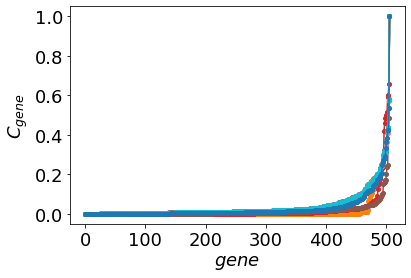

In [539]:
# plotting each observability score individually to check for consistency of the optimization routine
plt.figure();
plt.plot(data.sorted_C,'o-',ms=4);
plt.plot(data0.sorted_C,'o-',ms=4);
plt.plot(data1.sorted_C,'o-',ms=4);
plt.plot(data2.sorted_C,'o-',ms=4);
plt.plot(data3.sorted_C,'o-',ms=4);
plt.plot(data4.sorted_C,'o-',ms=4);
plt.plot(data5.sorted_C,'o-',ms=4);
plt.plot(data6.sorted_C,'o-',ms=4);
plt.plot(data7.sorted_C,'o-',ms=4); 
plt.plot(data8.sorted_C,'o-',ms=4);
plt.plot(data9.sorted_C,'o-',ms=4);
plt.ylabel(r'$C_{gene}$');
plt.xlabel(r'$gene$');


In [546]:
# getting mean of scores and sorting in ascending order
scores = np.squeeze(np.array([data.C,data1.C,data2.C,data3.C,data4.C,data5.C,data6.C,data7.C,data8.C,data9.C]),axis=2)
mean_scores = np.mean(scores,axis=0)
stdev_scores = np.std(scores,axis=0)
sorted_inds = mean_scores.argsort() 
sorted_mean_scores = mean_scores[sorted_inds] 
sorted_stdev_scores = stdev_scores[sorted_inds]
sorted_transcriptIDs = [data.keep_transcriptIDs[i] for i in sorted_inds]
sorted_genes = [data.genes[i] for i in sorted_inds]
sorted_locus_tags = [data.locus_tags[i] for i in sorted_inds]
sorted_proteins = [data.proteins[i] for i in sorted_inds]
sorted_locations = [data.locations[i] for i in sorted_inds]

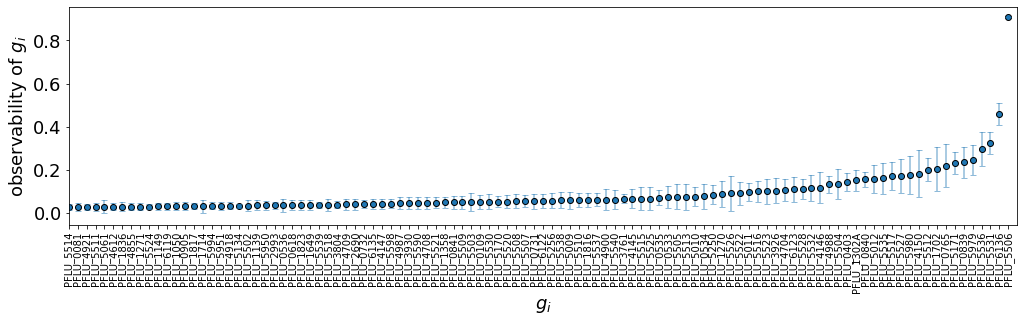

In [621]:
# visualizing the mean score with standard deviation as error bars
plt.figure(figsize=(17,4));
plt.plot(list(range(len(sorted_scores))),sorted_scores,'o',color='tab:blue',mec='black')
plt.errorbar(list(range(len(sorted_scores))),sorted_scores,yerr=sorted_stdev_scores,fmt='.',ms=0,color='tab:blue',\
             capsize=3,alpha=0.5);
plt.xticks(ticks=list(range(len(sorted_scores))),labels=sorted_locus_tags,fontsize=10,rotation='vertical')
plt.xlabel(r'$g_i$');
plt.ylabel(r'observability of $g_i$');
plt.xlim(400,len(sorted_mean_scores));

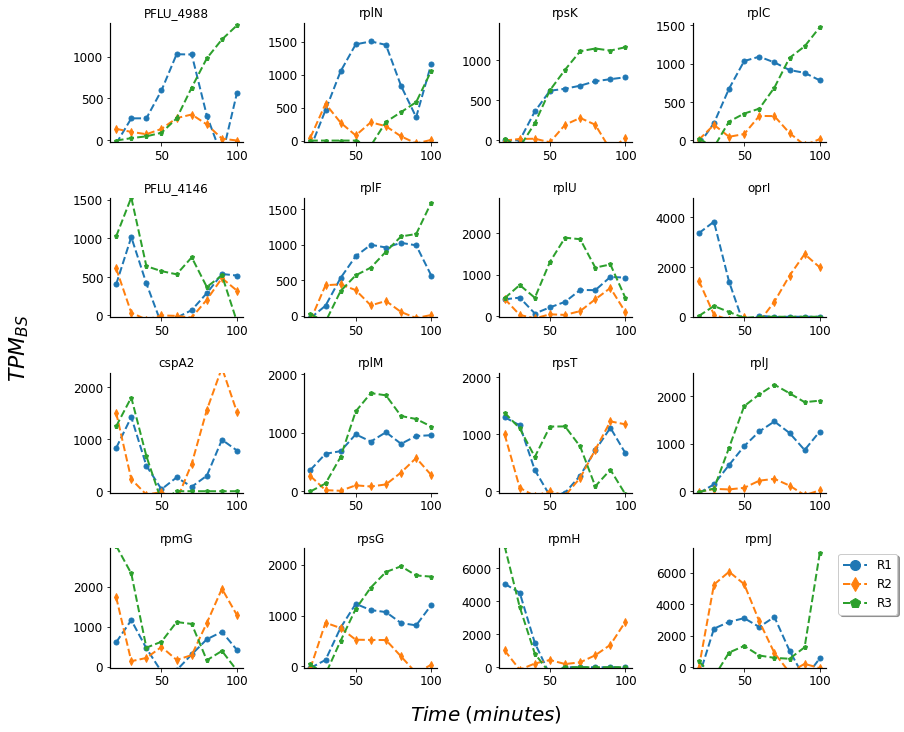

In [524]:
# plot bottom scorers or top scorers
k = 16
save_dir = 'figures/data_top50.pdf'
plot_gene_traces(data9,k,pltdim=(4,4),start='-1',savedir=save_dir,savefig=False,showfig=True)

#### Get the intergenic regions (or putative promoter regions) from the genbank (gbff) file

In [10]:
intergenic_records = get_interregions(genbank_path,intergene_length=100)
# Q: What should be the minimum intergene_length? 

doWrite = False
if doWrite:
    outpath = os.path.splitext(os.path.basename(genbank_path))[0] + "_ign.fa"
    SeqIO.write(intergenic_records, open('data/'+outpath, 'w'), 'fasta');

#### Given the gene's location, output the nearest promoter region. 

In [11]:
# get promoter sequences (intergenic regions) for all the genes modeled
promoter_records = get_promoterregions(data,intergenic_records,genbank_path,rel_dist_thresh=5000)

doWrite = False
if doWrite:
    outpath = os.path.splitext(os.path.basename(genbank_path))[0] + "_promoters.fa"
    SeqIO.write(promoter_records, open('data/'+outpath, 'w'), 'fasta');

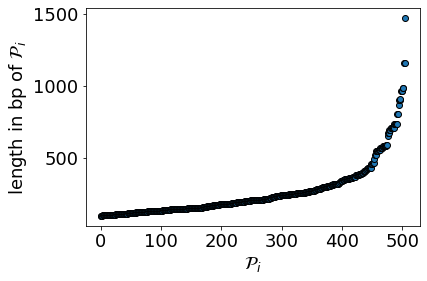

In [617]:
# plotting all putative promoter lengths
promoters = []
for record in promoter_records: 
    promoters.append(str(record.seq))
promoters = [promoters[i] for i in sorted_inds]
promoter_lens = [len(i) for i in promoters]
promoter_lens.sort()
plt.figure();
plt.plot(promoter_lens,'o',mec='black');
# plt.hlines(300,-10,600,color='red');
# plt.xlim(-10,len(promoter_lens)+10);
plt.xlabel(r'$\mathcal{P}_i$');
plt.ylabel(r'length in bp of $\mathcal{P}_i$');

#### Get promoter sequences and gene identity of top 20 or so (10 ribosomal protein coding genes and 10 other) and bottom 20 genes. 


In [586]:
# make a dataframe object which has the gene metadata
metadf = pd.DataFrame([sorted_locus_tags,sorted_genes,sorted_proteins,sorted_locations,\
        list(sorted_mean_scores),promoters]).T
metadf.columns = ['locus_tag','gene','protein','location','observability_score','promoter_sequence']
metadf

,locus_tag,gene,protein,location,observability_score,promoter_sequence
0,PFLU_0519,miaA,tRNA delta(2)-isopentenylpyrophosphate transfe...,"[588853, 589825, 1]",4.68994e-08,GTGTTTGGCGCCTGTATCGGCCTCATCGGGGGCACGCCCCCTTCCA...
1,PFLU_0530,rnr,ribonuclease R,"[601927, 604564, 1]",2.3224e-07,CCGGGGTGTTCCTCACTTGTATGCAACAAATACTTACAAGGATAAA...
2,PFLU_5407,corC,magnesium and cobalt efflux protein,"[5939101, 5939941, 1]",5.12369e-07,TGACCTGATTAACACCGACTCAATGTGGGAGGGGGCTTGCCCCCGA...
3,PFLU_6071,accC,biotin carboxylase,"[6644584, 6646000, -1]",0.000431026,TTTTTAATCCTCTCGCCCCAGGCTGTGCGGCCAACTATAAGTCTTT...
4,PFLU_4148,N/A,putative threonyl-tRNA synthetase,"[4589736, 4591659, -1]",0.000698705,GAGGATGCTCCTTTGGGTCGAGGACGAACGGCGATTCTCAGTGGGT...
5,PFLU_5058,N/A,putative DNA-binding protein,"[5558819, 5559806, -1]",0.000705653,ATATTACCGTCGATAGAAATCTCCTGTGGGAGCTGGCTTGCCTGCG...
6,PFLU_1279,N/A,putative outer membrane protein,"[1416130, 1416634, 1]",0.000749231,GACAGTCTTCAACTGTCGCCCGAAAGAGGCTGCCCGCTCACGCGCG...
7,PFLU_1153,rnt,ribonuclease T,"[1287752, 1288424, -1]",0.000873106,GGGAGGCTCCACTGGTTTCTACAACACTTCAAAGCGTCATACATCG...
8,PFLU_5139,N/A,cytochrome C oxidase (ubiquinol oxidase) subun...,"[5633025, 5635044, -1]",0.000966441,GCTCATCACCCAAACGCCCCGGTCTTTCTTAGTGGAAGGCCGGGGC...
9,PFLU_4183,N/A,amidophosphoribosyltransferase,"[4619511, 4621017, -1]",0.00110813,CGCATACAAGCAGCGAATGGTCGGAGCCTTGGTTCTGGTGGCGCTG...


In [601]:
# grab top 20 (10 riboProtein, 10 not)
# grabbing them manually while ensuring they are unique sequences
top = [505,504,503,502,501,500,499,498,497,495,493,488,485,481,480,479,470,466,462,461] # 4 to go
# grab bottom 20 
bottom = [0,1,2,3,4,5,6,7,9,10,11,12,13,14,15,16,17,18,19,20] # excluded 8 because sequence was duplicated
bottom.reverse()
selected = top+bottom

#### Write a fasta that contains the promoter sequences for the selected promoters 

In [603]:
# getting all promoter sequences that were selected into a dataframe and SeqRecord.
selmetadf = metadf.loc[selected].reset_index()
selected_promoters = []
for ii,tag in enumerate(selmetadf.locus_tag):
    for record in promoter_records:
        if tag in record.id:
            selected_promoters.append(SeqRecord(record.seq,id="%s_%s"%(tag,'promoter'),\
                description="%d-%d-%s%d"%(selmetadf.location[ii][0],\
                                        selmetadf.location[ii][1],\
                                        'strand',selmetadf.location[ii][2])))


In [604]:
# count number of unique promoter sequences
selected_promoter_seqs = []
for record in selected_promoters:
    selected_promoter_seqs.append(str(record.seq))

print('unique promoter sequences', len(set(selected_promoter_seqs)),'out of total genes selected',len(selected_promoter_seqs))

unique promoter sequences 40 out of total genes selected 40


In [606]:
# write all selected promoters to fasta
unique_selected_promoters = []
for ii in range(len(selmetadf)):
    unique_selected_promoters.append(SeqRecord(Seq(selmetadf.promoter_sequence[ii]),\
                                id="%s"%(selmetadf.locus_tag[ii]),\
                                description="%s, %s"%(selmetadf.location[ii],\
                                selmetadf.observability_score[ii])))
    
doWrite = False
if doWrite:
    outpath = os.path.splitext(os.path.basename(genbank_path))[0] + "_selected_promoters.fa"
    SeqIO.write(unique_selected_promoters, open('data/'+outpath, 'w'), 'fasta');

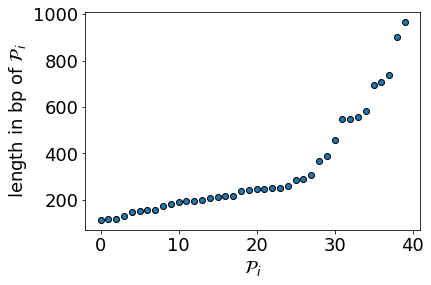

In [616]:
# length of each selected promoter sequence plotted
selected_promoter_lens = [len(i) for i in selmetadf.promoter_sequence]
selected_promoter_lens.sort()
plt.figure();
plt.plot(selected_promoter_lens,'o',mec='black');
# plt.hlines(300,-10,600,color='red');
plt.xlabel(r'$\mathcal{P}_i$');
plt.ylabel(r'length in bp of $\mathcal{P}_i$');
